<a href="https://colab.research.google.com/github/rileythejones/DS-Unit-2-Kaggle-Challenge/blob/master/RJ_assignment_kaggle_challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment

- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


### Doing

- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)


In [0]:
%%time

import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.utils.multiclass import unique_labels
from ipywidgets import interact, fixed
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

train = pd.merge(pd.read_csv('train_features.csv'), 
                 pd.read_csv('train_labels.csv'))

test = pd.read_csv('test_features.csv')
sample_submission = pd.read_csv('sample_submission.csv')

def wrangle(X):
    """Wrangles"""
    X = X.copy()
    
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')

    X['years'] = X['year_recorded'] - X['construction_year']    
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
   
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    return X


train = pd.merge(pd.read_csv('train_features.csv'), 
                 pd.read_csv('train_labels.csv'))
test = pd.read_csv('test_features.csv')
sample_submission = pd.read_csv('sample_submission.csv')
target = 'status_group'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8162696754422621
Wall time: 4min 26s


In [0]:
y_val[:10]

58046             non functional
41184             non functional
27587                 functional
53109                 functional
7245     functional needs repair
15062                 functional
52929                 functional
54947                 functional
20289             non functional
23917                 functional
Name: status_group, dtype: object

In [0]:
pipeline.predict_proba(X_val[:10])

array([[0.0047619 , 0.00238095, 0.99285714],
       [0.21190476, 0.02142857, 0.76666667],
       [0.88095238, 0.04047619, 0.07857143],
       [0.99285714, 0.00238095, 0.0047619 ],
       [0.30952381, 0.06428571, 0.62619048],
       [0.9547619 , 0.01190476, 0.03333333],
       [0.74761905, 0.20238095, 0.05      ],
       [0.54285714, 0.0547619 , 0.40238095],
       [0.07619048, 0.31904762, 0.6047619 ],
       [0.73333333, 0.0547619 , 0.21190476]])

In [0]:
y_val.value_counts()

functional                 7798
non functional             5517
functional needs repair    1043
Name: status_group, dtype: int64

In [0]:
y_pred_proba_functional = pipeline.predict_proba(X_val)[:, 0]
sns.distplot(y_pred_proba);


NameError: name 'y_pred_proba' is not defined

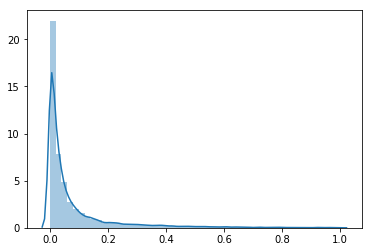

In [0]:
y_pred_proba_repair = pipeline.predict_proba(X_val)[:, 1]
sns.distplot(y_pred_proba_repair);


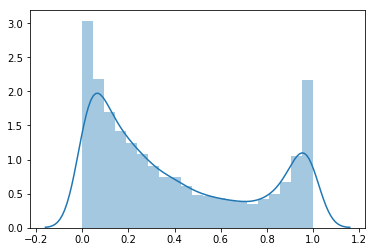

In [0]:
y_pred_proba_non_functional = pipeline.predict_proba(X_val)[:, 2]
sns.distplot(y_pred_proba_non_functional);

In [0]:
def plot_confusion_matrix(y_true, y_pred):

    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'True {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                        columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

def set_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba > threshold
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.show()
    print(classification_report(y_true, y_pred))
    plot_confusion_matrix(y_true, y_pred)


In [0]:

interact(set_threshold, 
         y_true=fixed(np.array(y_val)), 
         y_pred_proba=fixed(y_pred), 
         threshold=(0, 1, 0.02));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [0]:
classification_report(y_val, y_pred)

'                         precision    recall  f1-score   support\n\n             functional       0.59      0.60      0.60      8604\nfunctional needs repair       0.03      0.03      0.03       555\n         non functional       0.35      0.35      0.35      5199\n\n               accuracy                           0.49     14358\n              macro avg       0.33      0.33      0.33     14358\n           weighted avg       0.49      0.49      0.49     14358\n'

array(['functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)